# Become a sommelier

*A simple application of how data mining and simple supervised machine learning techniques can be applied to create a simple but still powerful code to guess the grape variety of which a bottle of wine was made from. In this report we go through the description of wines from different grapes and try to understand what are the similarities and differencies between wines.*

Have you ever wondered who writes the description on the wine label sold in supermarkets? If done by experts, they are called sommeliers. They are professional wine experts with wide range of knowledge about wine service and pairing it with food. The PhD of this profession is called [Master of Wine](https://en.wikipedia.org/wiki/Master_of_Wine) (MW). It many takes years of practice to obtain this degree. One of the hardest thing is to master blind tasting. 

Blind tasting is when a person is served a glass of wine (or other alcohol) and his task is to describe its characteristics, like color, body, acidity, taste, smell etc. Depending on the difficulty of the tasting the person might be further requested to guess the grape variety, vintage, country of origin etc. of that wine based on the features he just described. 

This sounds much like a machine learning task: based on a given description of wine characteristics decide what grape was used to produce the wine, in which country, what vintage etc. However a computer is not yet at the stage to smell or taste a glass of wine, therefore a collection of characterizations has to be given to it beforehand. 

Actually the hardest part of this project is to create a database of professional wine descriptions. 

This report is the first part of a project that intends to create a program that is capable of predicting what grape variety was used to create the examined wine based on a given semi-professional characterization. This first part will analyse the data and highlight the characteristics of grape varieties using simple **Natural Language Processing** (NLP) techniques using the **nltk** package, while the second part will do the actuall model building, training and predicting. Here we will cover the following topics:

1. Understanding the data at hand
2. Word tokenization
3. Filtering noise
4. Part of Speech (POS) tagging and Lemmatization
5. Comparison
   - Common words
   - Disjoint words
6. Conclusion
7. Appendix: Getting the data
8. References

# 1. Understanding the data at hand

 To build a robust system that determines the grape variety based on a description one needs good quality data. Probably the most well known wine related database between the machinel learning community is the [Wine Data Set](https://archive.ics.uci.edu/ml/datasets/wine) from the **UCI Machine Learning Repository**. Although, it contains a wide range of information it is irrelevant for us, since does not give description about the wine. [Wine-searcher](https://www.wine-searcher.com/) could be a good choice especially since it has an API to its database, but many of its services are not free. Some others like [LCBO API](https://lcboapi.com/) and [Global Wine Score](https://www.globalwinescore.com/) have the same problems.
 
 Finally if one wants to work with a special database as we do, which contains name of the wine, the producer, country of origin, alcohol level, color, the grape varieties used to make it and at least a half professional tasting description, one has to go out and scrape the web. Possible sources are [Wine Enthusiast](https://www.winemag.com/), [Bibendum](https://www.bibendum-wine.co.uk/), [Majestic Wine](https://www.majestic.co.uk/) etc. None of them are perferct or contain all the information we need for all wines, but most of the times they give description and grape variety which is our two most wanted information. 
 
 In the Appendix we will give a short description about how did we scrape through the Bibendum and Majestic Wine websites to collect the needed information. As recently we found it out, much later after we started this project, there were other attempts to achieve the same goal as ours. There is a data collection about wines on [Kaggle](https://www.kaggle.com/zynicide/wine-reviews) by *zackthoutt*. It will be a good out of sample test source in my follow up article when we try to present a simple blind taster program.
 
 **Be aware that the data used in this report is just a small subset taken from these websites and they are preprocessed so that it can be used as an input for analysis. The raw information retrieve from them is NOT presented nor shared with anyone. This report was not sponsored by any of the mentioned entities and the author does not have any relation to them. The retrieved data is only used to do text analysis and statistics on it but not used to make profit.**

To start to examine the data at hand we start importing useful packages into Python. This project relies on *Python 3*. In this report we havily rely on the following three categories of packages:
1. Packages for data manipulation: pandas, numpy
2. Packages for text analysis: re, nltk
3. Packages for data visualization: seaborn, matplotlib.

Make sure that these libraries are installed on your computer if you want to run the code in this report. 

In [1]:
%matplotlib inline
# packages and methods for data manipulation
import pandas as pd
import numpy as np
from functools import reduce

# packages and methods for text analysis
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

# function to split data into train and test samples
from sklearn.model_selection import train_test_split

# packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt


Then we load the data that contains the scraped and pre-cleaned information (see Appendix) about the wines. Below we can see how does the whole data look like. In this report we are mainly interested in the *grape_variety* and *description* columns. 

In [2]:
filename = '../DataBase/5_grape_db.xlsx'

a0 = pd.read_excel(filename)
a0.head()

,abv,colour,country,description,grape_variety,name,Body
0,13.5,red,USA,this wine has concentrated depth and purity of...,pinot noir,A to Z Pinot Noir 2014,light
1,13.5,red,Argentina,"a delicate, floral wine with soft cherry and s...",pinot noir,Alamos Seleccion Pinot Noir 2016,medium
2,12.5,red,Italy,"a medium-bodied wine, with aromas and flavours...",pinot noir,Alois Lageder Alto Adige Pinot Noir 2014,medium
3,13.5,white,Italy,very fresh aromas and flavours of gooseberry a...,sauvignon blanc,Alois Lageder Terlaner Sauvignon Blanc 2016,medium
4,13.5,red,Argentina,this wine has concentrated aromas and flavours...,cabernet sauvignon,Argento Cabernet Sauvignon 2014,full


In machine learning precision of prediction can be increased by obtaining a big chunk of good quality data. In this data set, none of the grapes has thousands of samples, therefore we have to make a compromise. The *varieties* variable serves to filter out grapes that do not have more samples than *limit*.

In [3]:
result = a0['grape_variety']
limit = 40
## removing varieties that have only one member in the database
counts = nltk.Counter(result)
varieties = [key for key in counts if counts[key] > limit]
data_input = a0[a0['grape_variety'].isin(varieties)].reset_index()


We will use 67% of the data to analyse the descriptions of wines. This will be used as a train set in the follow up report. Then we visualize how many samples are there from each grape variety. 

In [4]:
# split the data into train and test
combined_features = ['description', 'grape_variety']
target = 'grape_variety'

X_train, X_test, y_train, y_test = train_test_split(data_input[combined_features], data_input[target], 
                                                    test_size=0.33, random_state=42)


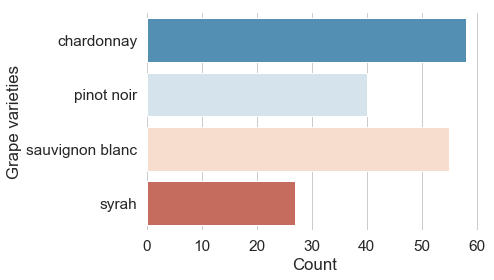

In [5]:
# plotting the number of samples for each grape variety
sns.set(style="whitegrid", font_scale=1.4)
ax = sns.barplot(x='description', y='grape_variety', data=X_train.groupby('grape_variety', as_index=False).count(), 
                 palette=sns.color_palette("RdBu_r",4))
ax.set_xlabel('Count')
ax.set_ylabel('Grape varieties')
sns.despine(left=True, bottom=True)

The grape varieties in the train set are not equally represented. The white wines, the *chardonnay* and the *sauvignon blanc* have the most samples. Simply because of that feature we can already expect that some words will be more frequent in the white wine descriptions than in the red ones. 

To start our analysis, we aggregate all the descriptions into one place by grape varieties. During the aggregation process we use double *lambda* functions: the first to extract the descriptions belonging the a grape variety (described by *z*) and the second applies the *reduce* function that in this case takes the consecutive elements of *z* and joins (adds) them together.

In [6]:
# aggregate description by grape type
grouped = X_train[['grape_variety', 'description']].groupby(['grape_variety']).agg(
    {'description': lambda z: reduce(lambda x,y: ''.join(x+y), z)}
)
grouped.head()

,description
grape_variety,
chardonnay,' quest to create an australian rival to the t...
pinot noir,as seen on tv.the belen estate in chile 's cas...
sauvignon blanc,"this classic displays elements of gooseberry ,..."
syrah,are dedicated to showcasing the wide range of ...


# 2. Word tokenization
A lousy definition of tokenization could be: given a character sequence, tokenization is the task of chopping it up into pieces, called tokens and probably throwing away certain characters, such as punctuation [1]. In our case it means we retrieve each individual word one-by-one in the description column and store them as a list of words under the column *token*. This way we will be able to compare the words used in each grape variety. One could write a fancy function to do this job, but the *nltk* package contains already a nice function for it, called *word_tokenize*. 

In [7]:
# tokenize the combined text
grouped['tokens'] = grouped.loc[:, 'description'].apply(word_tokenize)


We write a function that counts how many times has a word occured in a grape variety and creates a new dataframe with the name of the grape, the word (token) that was used for the grapes description, the number of times that token has occured and finally we also rank which tokens were the most frequent ones.

In [8]:
def word_count_df(df, src_col, out_col=('grape', 'token', 'count')):
    '''Take the list of tokens, count the tokens and create a dataframe with the grape, its tokens and their counts'''
    dfp = pd.DataFrame()
    for ii in df.index:
        dist = nltk.FreqDist(df.loc[ii, src_col])
        dftmp = pd.DataFrame(dict(zip(out_col, ([ii]*len(dist.keys()), list(dist.keys()), list(dist.values())))))
        dfp=pd.concat([dfp, dftmp], ignore_index=True)
    return(dfp)

tkn_count = word_count_df(grouped, 'tokens', out_col=('grape', 'token', 'count'))


In [9]:
tkn_count['rank']=tkn_count.groupby(['grape'], as_index=False)['count'].rank(ascending=False)

To have an initial idea what words are the most frequent to each wine we plot these words. White wines are represented by greenish color while the red ones with redish color.

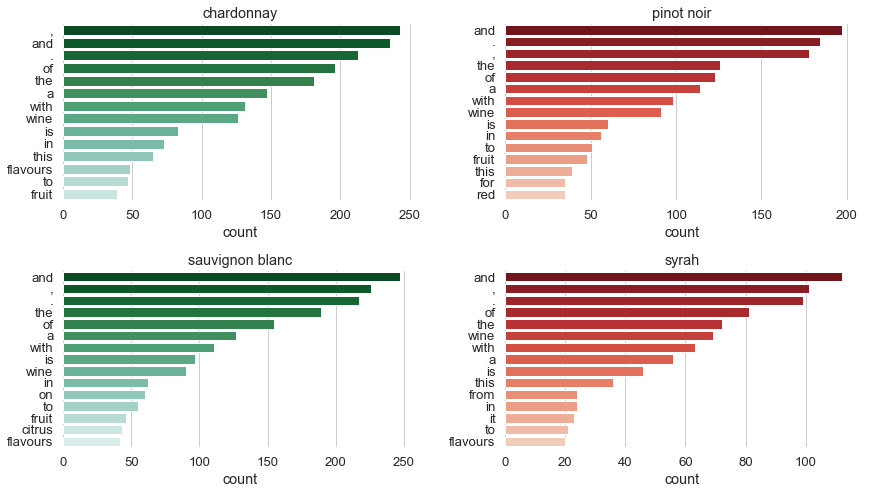

In [10]:
# plot the word count of each grape type
def barplot_wordcounts(df, types, m=2, n=2, limit=10):
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axarr = plt.subplots(m, n, figsize=(13, 7))
    plt.subplots_adjust(top=0.99, bottom=0.15, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)
    ii = 0
    for row in axarr:
        for col in row:
            if ii < len(types):
                col.set_title(types[ii])
                if types[ii] in ['chardonnay', 'sauvignon blanc']:
                    palette_def = 'BuGn_r'
                else:
                    palette_def = 'Reds_r'
                filt_cond = (df['rank'] <= limit) & (df['grape']==types[ii])
                sns.barplot(x='count', y='token', ci = None,
                    data=df[filt_cond].sort_values('count', ascending=False), 
                    ax = col,
                    palette=sns.color_palette(palette_def,limit+3))#("Blues_r",15))
                ii += 1
                sns.despine(left=True, bottom=True)
                col.set_ylabel('')

barplot_wordcounts(tkn_count, grouped.index, m=2, limit=15)

As we can see the most frequent 15 words are basically filling words or some kind of punctuations. Except for the word 'citrus' (sauvignon blanc) and 'red' (pinot noir) there are no other words in the plot that may give us a clue about the variety of the grape. Therefore it makes sense to filter the text from these filling words that make noise in the text and does not help to determine the variety of the grape. 

# 3. Filtering noise

In the first round we will apply a simple non alphabetic character remover to get rid of words with length of 1 and 2 characters, full stops, commas, numbers, etc. Then we apply a stopword filter from the nltk.stopwords package appended by some additional words that do not contain any usefool information about the variety of grapes like the word 'wine' and some more. These words appear above as some of the most frequent words to describe a wine.

In [11]:
# pattern for numbers | words of length=2 | punctuations | words of length=1
pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')

# remove tokens that are matching with the pattern
tkn_count['token'] = tkn_count['token'].apply(lambda t: pattern.sub('', t))
tkn_filt = tkn_count[-tkn_count['token'].isin([''])].reset_index()

# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavours', 'aromas', 'palate']
stop_words = stop_words + stop_append

# removing stopwords
tkn_filt1 = tkn_filt[-tkn_filt['token'].isin(stop_words)].reset_index()
tkn_filt1['rank'] = tkn_filt1.groupby(['grape'], as_index=True)['count'].rank(ascending=False)
tkn_filt1 = tkn_filt1.drop(['level_0', 'index'], axis=1)

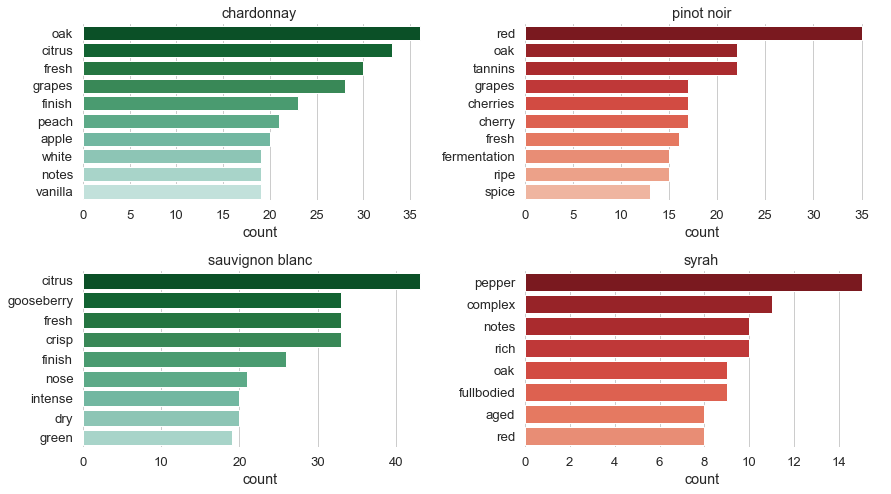

In [12]:
barplot_wordcounts(tkn_filt1, grouped.index, m=2)

After filtering, some of the taste and smell characteristics start to apppear in the most frequent words. These words differentiate the varieties. There are still some words that do not bear any information about the difference between the grapes, but for the moment we leave them in.

# 4. Part of Speech (POS) tagging and Lemmatization

The filtering step allows us to remove some basic noise from the collection of words but the remaining collection of words is still not clean enough. Particularly, some words may appear in different forms while actually having the same meaning. For example, in the case of pinot noir we can see the words cherry and cherries. They are the same but the former is singular noun while the latter is plural noun. To resolve this phenomena we can apply lemmatization. This process tries to group words into their common form. For that we use the *WordNetLemmatizer* from *nltk*. As an input it takes a string that tells the lemmatizer if the second argument, the token is a noun, verb, adjective or adverb. Therefore, first we write a few helper function that will help us to make this decision. 

First we prepare the tokens to be able to lemmatize. We apply *nltk*'s **part of speech (POS)** tagger [2]. This is one of the most important steps of NLPs. POS tagging will decide to which word class (noun, verb, etc.) a token belongs to based on a relationship to adjacent and related words. The POS tagger requires a list of tokens as an input and creates a list as an output with elements of tuples, where the first item is the token and the second is a tag (e.g. *VB* referring to verb).  

In [13]:
# helper functions to transform tags into nltk nouns, verbs, adjectives and adverbs
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    

In [14]:
lemm = WordNetLemmatizer           # creating a lemmatizer instance
ptags = nltk.pos_tag(tkn_filt1['token'].tolist())      # getting the pos tags for each token
ptags_wn = [(t[0], penn_to_wn(t[1])) for t in ptags]   # transforming pos tags into nouns, verbs, adj and adv
lems = [lemm.lemmatize(tag[1], tag[0]) for tag in ptags_wn]   # retrieving the common meaning roots
tkn_filt1['token'] = lems

After finding the lemmas we reduced the number of individual verbs present in the tokens, like there are no *cherries* in the *pinot noir*, they have been turned into cherry, increasing the number of its counts. Some of the characteristics of each grape variety starts to appear, like an aged chardonnay is kept in an *oak barrel* and bears *citrus* like tastes. *Pinot* has often *cherry, spicy, raspberry* falvors that do appear in its most frequented words.

In [15]:
tkn_filt1 = tkn_filt1.groupby(['grape', 'token'], as_index=False)['count'].sum()


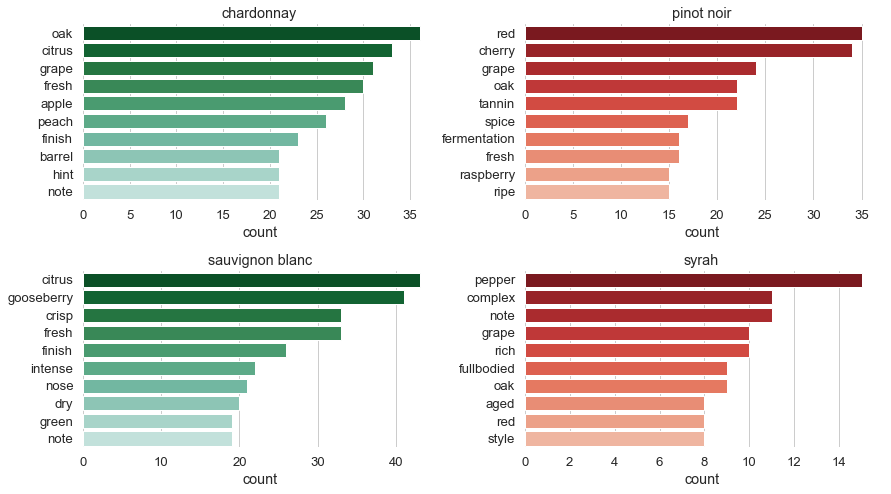

In [16]:
tkn_filt1['rank'] = tkn_filt1.groupby(['grape'], as_index=True)['count'].rank(ascending=False)
barplot_wordcounts(tkn_filt1, grouped.index, m=2)

However there are still many words that do not give any hint about which grape variety was used for a wine. The words *grape, note, style* etc. does not add any feature to the description of the grape. One way to solve this problem would be to look up manually all these words and filter them out, but on one hand this would be very tedious job and on the other we could expect that our model becomes overfitted. 

Instead a better approach would be a kind of entity chunking [3,4]. This is a complex procedure where based on linguistic knowledge one tries to extract information from the text. For example, one could build a model that finds the features in the text that belong to different predifined categories, like taste, palate, acidity etc. For now, we will not implement this technique.

Let us now investigate what are the common and disjoint words for these grapes. 

# 5. Comparison
To identify what makes our different grape varieties unique in terms of description of the wine we decompose our tokens into common words to all grape types and disjoint words, which can be only found in one of the grape descriptions. 
## Common words
As we could see from the plot of most frequent words per grape varieties there are overlap between the grapes. Finding common words can be a way of finding words that are not giving much information about the individual grape types. Although, we have to keep in mind 2 things: a) usually they are not equally distributed between the grapes, b) being a common word to all grapes does not directly mean that it has no feature behavoir to one of the grapes. We will see examples for the latter case later. Also note, that analysing the common words neglects all the words that are not found in the description of all of the grape types. After finding the common words we take a look at the correlation of their frequency between the grape types.

In [17]:
# changing name of columns to help finding the common words
dfs = []
for gr in varieties:
    tmp = tkn_filt1[tkn_filt1.grape == gr]
    tmp = tmp.add_suffix('_'+gr)
    tmp.columns=tmp.columns=tmp.columns.str.replace('token_'+gr,'token')
    dfs.append(tmp)
    
# merge each grape variety with each other on tokens
df_final = reduce(lambda left,right: pd.merge(left,right,on='token', how='outer'), dfs)

In [18]:
# by removing NAs from the dataframe we get the common words
df_common = df_final.dropna()
cols = df_common.columns.str.contains('count') | df_common.columns.str.contains('token')
df_common = df_common[df_common.columns[cols]]
df_common.corr()      # calculate the correlation

,count_pinot noir,count_sauvignon blanc,count_chardonnay,count_syrah
count_pinot noir,1.000000,0.449791,0.714380,0.465864
count_sauvignon blanc,0.449791,1.000000,0.560165,0.296221
count_chardonnay,0.714380,0.560165,1.000000,0.629290
count_syrah,0.465864,0.296221,0.629290,1.000000


The idea behind the correlation of common words is the following. If the frequency of a word is roughly the same for each grape type it means that word is probably just a filling word, not giving much information of any of the grapes. This scenario increases the correlation. If the frequencies are different, especially if it is very large for one of the grapes and small for the others that means, that word is probably a feature of one of the grapes and this would decrease the overall correlation. This whole argument is based on the assumption that each grape has the same amount of description sample with roughly the same number of tokens in it. But we know that this assumption is not true. 

Chardonnay has the largest sample size and the most tokens, it is understandable that it has large correlation with the other grape types. Chardonnay and Pinot Noir are used together to make champagne, in France both of them are usually oaked and also usually cultivated in the same wine region with similar teroir [5], therefor the correlation increases between them. Chardonnay is usually medium to full budied and has different tastes and flavors than Sauvignon Blanc which is often light budied and gives a feeling of freshness [6]. This might explain the lower level of correlation between them. Chardonnay and Syrah are both called big wines with deeper colors that is why Syrah is more correlated to Chardonnay than to Pinot Noir, which is lighter in color and easy to drink wine [7]. 

The correlation table also highlights that when comparing wines with each other it is not a simple categorization of red and white. Some reds have more similarities to whites. The color difference is mostly (but not entirely) due to the wine making process [8]. After the white grape is harvested the skin is separated from the juice while for red grapes usually the juice and the skin is sent to fermantation together. 

Let us now look at which words are the most frequent for all the grape types between all the common words. We cannot simply just add up the number of occurences of a word for each grape because the range of the occurances between grapes are not on the same scale, due to the fact that the sample sizes of the grape descriptions are different. Therefore, first we normalize the counts of word occurences within each grape variety using the *MinMaxScaler* of *sklearn* that outputs numbers between 0 and 1. One could use other scalers (like the normal scaler) but this one does not assume a distribution of samples, plus the outputs are non negative numbers helping us to do further analysis. Then we add up the normalized values (represented by the freq column) and sort them to see which words are the most frequent ones.

In [19]:
# perform normalization of counts using the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_norm = df_common.copy()
sort_col = df_norm.columns.str.contains('count')
df_norm[df_norm.columns[sort_col]] = scaler.fit_transform(df_norm[df_norm.columns[sort_col]])
df_norm['freq'] = df_norm[df_norm.columns[sort_col]].sum(axis=1)

ind = df_norm['freq'].sort_values(ascending=False).index
df_norm.loc[ind[:10], ]  # visualize the 10 most frequent word within grape verieties

,token,count_pinot noir,count_sauvignon blanc,count_chardonnay,count_syrah,freq
298,grape,1.000000,0.40625,0.857143,0.9,3.163393
453,oak,0.913043,0.12500,1.000000,0.8,2.838043
277,fresh,0.652174,1.00000,0.828571,0.3,2.780745
450,note,0.478261,0.56250,0.571429,1.0,2.612189
255,finish,0.347826,0.78125,0.628571,0.5,2.257648
318,hint,0.478261,0.37500,0.571429,0.6,2.024689
562,ripe,0.608696,0.31250,0.400000,0.4,1.721196
386,made,0.304348,0.46875,0.342857,0.5,1.615955
449,nose,0.347826,0.62500,0.228571,0.4,1.601398
141,complex,0.217391,0.03125,0.285714,1.0,1.534356


Not surprisingly the word *grape* is the most common between all grape types. In the first ten occurances there are words like *note*, *grape* and *made* which are probably just noise words not giving any additional information about the grape types. 

But by carefully looking at the scores, we can see that for example the word *oak* is important for the Pinot Noir, Chardonnay and Syrah, but not for the Sauvignon Blanc. Also the word *complex* is rather characteristic for Syrah but not much for Pinot Noir and Chardonnay and especially not for Sauvignon Blanc. 

Let us visualize the importance of each common word within the grape types. We will calculate what is the proportion of a word used in a grape compared to the other grapes. 

Text(0,0.5,'token')

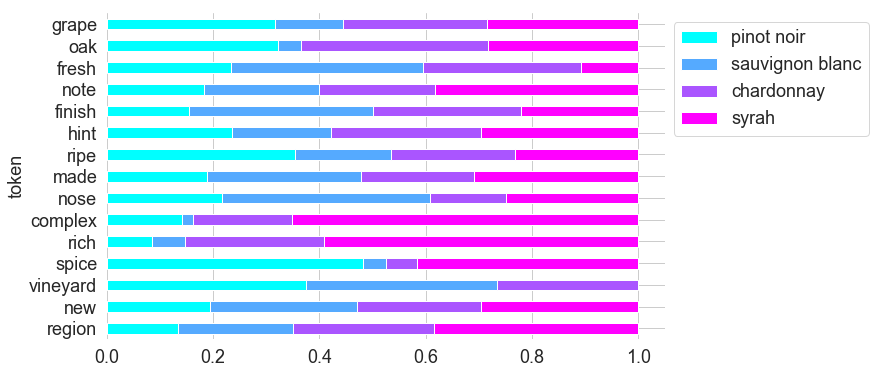

In [20]:
# preparing the stacked barplot
from matplotlib import cm
import matplotlib
cmap = cm.get_cmap('cool')
fsize = 18

dfplot = df_norm.sort_values(by='freq',ascending=False)
dfplot.index = dfplot['token']
sort_col = dfplot.columns.str.contains('count')
dfplot['csum'] = dfplot[dfplot.columns[sort_col]].sum(axis=1)
sort_col = dfplot.columns[dfplot.columns.str.contains('count')]

# creating the proportion columns
llabel = []
for col in sort_col:
    llabel.append(col.replace('count_',''))
    dfplot[col] = dfplot[col] / dfplot['csum']

# plotting
ax = dfplot.loc[list(reversed(dfplot.index[:15])), sort_col].plot(kind='barh', stacked=True, cmap=cmap, 
                                                                  figsize=(10, 6), fontsize=fsize)
ax.legend(llabel, bbox_to_anchor=(1., 1), fontsize=fsize)
ax.set_facecolor('w')
ax.set_frame_on(False)
ax.set_ylabel(ax.get_ylabel(), fontsize=fsize)

In the above figure we plot 15 most frequent words with the most frequent one being at the top. The words like *finish, hint, made* and *new* are roughly equally important for each wine. These words will not add information about the grape variety. However, the words *oak, rich, spice* and *complex* has negligible meaning for the Sauvignon Blanc, while the word *complex* seems to be really descriptive for the Syrah. *Spice* is important for the Pinot Noir and Syrah and less important for the two white grapes. This means that when training a predicting model this word can be confusing and may contribute to the mixing up of these to grapes when predicting their grape type. 

## Disjoint words

Now we turn to the words that are unique to each grape type. We expect to find some very characteristic features that may be unique for the grape type in question. 

In [21]:
# define a new dataframe container for the unique words
df_unique = pd.DataFrame()
for gr in varieties:
    cond = ~(df_final.columns.str.contains(gr) | df_final.columns.str.contains('token'))
    ind = df_final[df_final.columns[cond]].isna().all(1)  # find unique words in each column
    tmp = df_final.loc[ind, ~cond]
    tmp.columns = tmp.columns.str.replace('_'+gr, '')
    df_unique = pd.concat([df_unique, tmp], ignore_index=True, sort = True)

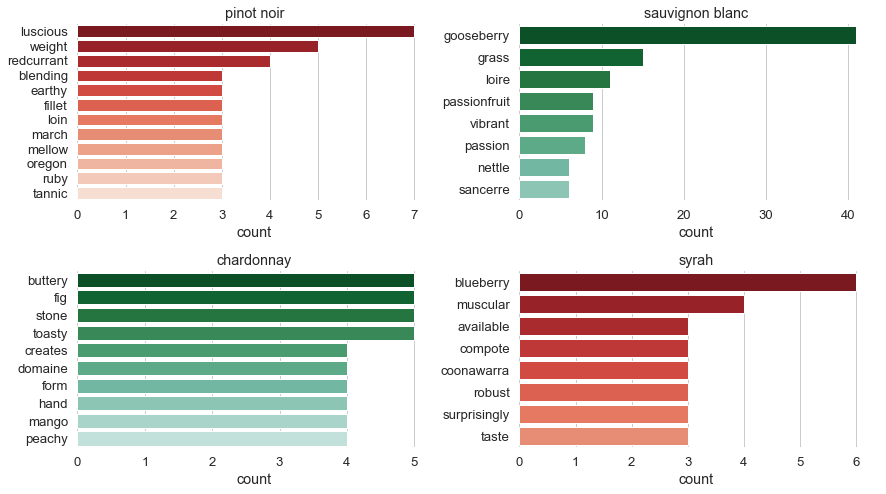

In [22]:
# rank and sort the words and then plot the outcome
df_unique['rank'] = df_unique.groupby(['grape'], as_index=False)['count'].rank(ascending=False)
barplot_wordcounts(df_unique, varieties, m=2)

Finally, we can see some true grape characteristics. However we have to keep in mind that these words are not necesarrily the best describers. It can happen that the best feature of a grape also appears (maybe rarely) in another one and our procedure has filtered it out, since we are showing only the common and disjoint (but not partially disjoint) features. 

Buttery aromas and toasty flavors are indeed characteristic to Chardonnay [9]. Look at Sauvignon Blanc's *gooseberry* count. That taste is indeed very frequent to that grape [10]. Just as *grass* and *passion fruit*. 

We also find a few words like *hand, creates, available, surprisingly* etc. that are not really grape dependent. These will also add some noise to the analysis. 

From these words we can actually see that the most relevent type of words that describe important characteristics about the grapes are nouns and adjectives. Verbs usually describe action and not features of a grape. Let us see, how many nouns, adverb, adjectives and verbs are in these unique words.

In [23]:
# finding POS tags
df_unique['pos'] = df_unique.apply(lambda row: penn_to_wn(nltk.pos_tag([row['token']])[0][1]), axis=1)
df_unique.groupby([ 'pos']).count()[['count']]

,count
pos,
a,101
n,848
r,89
v,200


Indeed, nouns are far more numerous than any other category. Nouns and adjectives together give more than two thirds of the words. We could replot the most important words after filtering for nouns and adjectives, but the outcome would be the same. This is a bit surprising since the word *creates* is probably a verb but it was tagged to be a noun. This shows the weakness of a simple POS tagging. This gives room for improvement on this project.

# 6. Conclusion
In this report we presented a simple Natural Language Processing approach based on word analysis to derive characteristic features of grape varieties from semi-professional wine descriptions. 

It was possible to show that although the descriptions were not well structured and contained a lot of irrelevant information with respect to the grape varieties we could extract grape characteristic nouns and adjectives. We showed that there are many common words used for each grape variety, but one can also find important words that belong to only one grape. These findings help to understand the background of the decisions made by a grape variety forecaster. Such kind of forecaster will be presented in the [next report](https://diveki.github.io/projects/sommelier.html). 

Since this analysis is based on a simplistic approach there is plenty of rooms for improvement:
- Collecting much more data and preferably less noisy data from professional wine experts.
- Write better noise filters that may remove words that do not contain important information about the grape.
- Improve POS tagging to find the right tags .
- Improve lemmatization, since there were many words not identified as the same token while having slightly different forms.
- One could apply stemming too.
- Write a complex code for information extraction into categories like taste, aroma, flavor, palatte, body etc. Finding words into these predefind categories could boost the performance of an algorithmic sommelier by a lot. 

Finally we showed that **using methodical analysis, algorithms can help people to become excellent sommeliers.**

If you have any questions, observations or suggestions please contact me at [diveki@gmail.com](diveki@gmail.com). You can also fork this project from [my GitHub repository](https://github.com/diveki/WineSommelier) or you can take a sneaky look at [my GitHub Pages website](https://diveki.github.io). 



# 7. Appendix: Getting the data
## Scraping
We were using the *Bibendum* and *Majestic Wine* websites to extract relevant information. You can find the two python codes [here](https://github.com/diveki/WineSommelier/tree/master/Scraping). Unfortunately, there is a great chance that the *webScraping.py* code will fail since Bibendum has re-structered its website after we have completed the scraping code.

The codes heavily rely on the *requests, Beautiful Soup* and *re* python packeges. The code loops through each page on the website that contains the list of wines and saves down their name and the link they point to into a wine class. The wine class is initialized by the name of the wine and its link. This class has methods to retrieve the description text about the wine and any other interesting detail about the wine, like name of producer, country, alcohol level, grape variety, body etc. Unfortunately these additional information are not present in all wines. Therefore we step through on each of them and fill the missing information with NAs. Finally the data is saved to the disk in .xlsx format. The combined data from Bibendum and Majestic Wine (at July 2018) builds upt to a total of 2366 items. 

## Data cleaning
- We take any text based input and turn it into lower case characters and removed any accents to make everything uniform. 
- In some cases the body was not defined separately but mentioned in the text. We wrote a function that tries to extract that information if it is missing.
- If grape name was not given separately we tried to retrieve it from the wine name with a function.
- There are mispelled grape names and different grape names referring to the same grape in the raw text. In different countries the same grape is called differently. To make a collection of uniform names we tried to identify these issues and correct them.
- Removed % from alcohol level
- Sometimes in the description they mentioned the name of the actual grape, we replaced these instances with the word grape.
- Sometimes the color of the wine is mentioned in the description, we removed those colors.

We tried to pay attention to leave as less hints about the grape in the description as possible. That required removing words from the text and sometimes leaving behind sentences that feel strange for a human being. 

Unfortunately, from the 2366 items only a small portion can be used for machine learning purposes becuase many of those grapes are mentioned only a few times or once. That is why this work is restricted only to 4 single grape variety. We left out blends intentionally. 

The database that we publish with this work contains 5 major grape types: Chardonnay, Sauvignon Blanc, Pinot Noir, Syrah (Shiraz) and Cabernet Sauvignon. These belong to the most famous and favorite grape types in the world. If you go to a wine shop to get a bottle the chance that you choose one of these is really big. 




# 8. References

1. https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
2. https://www.nltk.org/book/ch05.html
3. https://www.nltk.org/book/ch07.html
4. https://spacy.io/usage/linguistic-features
5. https://www.jancisrobinson.com/learn/grape-varieties/white/chardonnay
6. https://www.winespectator.com/drvinny/show/id/48344
7. https://justwines.com.au/blog/shiraz-vs-pinot-noir/
8. https://www.vivino.com/wine-news/the-differences-in-red-and-white-winemaking
9. http://wine-tasting-reviews.com/wine-types-varieties-grapes/white-wine-faq/white-wine-varities/37-chardonnay-wine-flavor-aroma-characteristics.html
10. https://winefolly.com/review/sauvignon-blanc-wine-taste-food-pairing/